In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Sample - Superstore.csv", encoding="ISO-8859-1")
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
df = df.dropna(subset=["Order Date"])

# Intermittent series option A: daily order count (often has many zeros)
daily_orders = (
    df.groupby("Order Date")["Order ID"]
      .nunique()
      .asfreq("D")
      .fillna(0)
      .astype(int)
)

y = daily_orders.rename("y")
y.head()


,y
Order Date,
2014-01-03,1
2014-01-04,1
2014-01-05,1
2014-01-06,3
2014-01-07,1


Zero-demand days: 15.2%


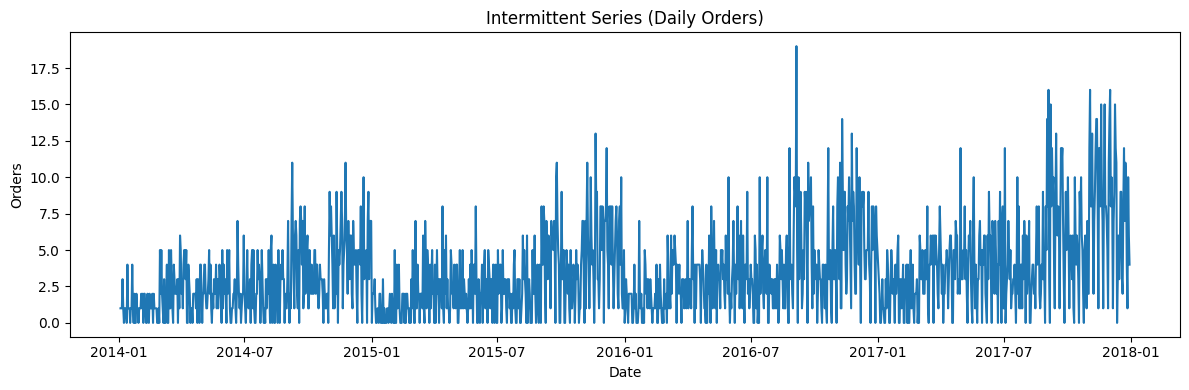

In [30]:
zero_rate = (y == 0).mean() * 100
print(f"Zero-demand days: {zero_rate:.1f}%")

plt.figure(figsize=(12,4))
plt.plot(y)
plt.title("Intermittent Series (Daily Orders)")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.tight_layout()
plt.show()


In [31]:
# ----------------------------
# 2) Train/Test split
# ----------------------------
h = 30  # forecast horizon (days)
train = y.iloc[:-h]
test  = y.iloc[-h:]
train.tail(), test.head()



(Order Date
 2017-11-26     8
 2017-11-27     7
 2017-11-28     5
 2017-11-29     1
 2017-11-30    11
 Freq: D, Name: y, dtype: int64,
 Order Date
 2017-12-01    14
 2017-12-02    16
 2017-12-03     8
 2017-12-04    10
 2017-12-05     8
 Freq: D, Name: y, dtype: int64)

In [32]:
def croston_forecast(y, h, alpha=0.1):
    y = np.asarray(y, dtype=float)
    n = len(y)

    # demand size estimate (z) and interval estimate (p)
    z = 0.0
    p = 1.0
    q = 0  # time since last demand

    # initialize using first non-zero demand
    nz = np.where(y > 0)[0]
    if len(nz) == 0:
        return np.zeros(h), {"z": 0.0, "p": 1.0}
    first = nz[0]
    z = y[first]
    p = max(1.0, first + 1.0)
    q = 0

    for t in range(n):
        if y[t] > 0:
            z = alpha * y[t] + (1 - alpha) * z
            p = alpha * (q + 1) + (1 - alpha) * p
            q = 0
        else:
            q += 1

    rate = z / max(p, 1e-9)  # demand per period
    fc = np.full(h, rate)
    return fc, {"z": z, "p": p, "rate": rate}


In [33]:
def sba_forecast(y, h, alpha=0.1):
    fc, st = croston_forecast(y, h, alpha=alpha)
    # Syntetos-Boylan Approximation (bias correction)
    corr = (1 - alpha / 2.0)
    return fc * corr, {**st, "corr": corr}


In [34]:
def tsb_forecast(y, h, alpha=0.1, beta=0.1):
    y = np.asarray(y, dtype=float)
    n = len(y)

    # initialize
    nz = np.where(y > 0)[0]
    if len(nz) == 0:
        return np.zeros(h), {"z": 0.0, "p": 0.0, "rate": 0.0}

    first = nz[0]
    z = y[first]          # demand size
    p = 1.0 / (first + 1) # rough initial probability

    for t in range(n):
        if y[t] > 0:
            p = beta * 1.0 + (1 - beta) * p
            z = alpha * y[t] + (1 - alpha) * z
        else:
            p = beta * 0.0 + (1 - beta) * p
            # z stays the same when no demand

    rate = p * z
    fc = np.full(h, rate)
    return fc, {"z": z, "p": p, "rate": rate}


In [35]:
def rmse(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    return np.sqrt(np.mean((a - b) ** 2))

def mae(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    return np.mean(np.abs(a - b))

cro_fc, _ = croston_forecast(train.values, h, alpha=0.1)
sba_fc, _ = sba_forecast(train.values, h, alpha=0.1)
tsb_fc, _ = tsb_forecast(train.values, h, alpha=0.1, beta=0.1)

idx = test.index
cro_fc = pd.Series(cro_fc, index=idx, name="Croston")
sba_fc = pd.Series(sba_fc, index=idx, name="SBA")
tsb_fc = pd.Series(tsb_fc, index=idx, name="TSB")

results = pd.DataFrame({
    "Model": ["Croston", "SBA", "TSB"],
    "RMSE": [rmse(test, cro_fc), rmse(test, sba_fc), rmse(test, tsb_fc)],
    "MAE":  [mae(test, cro_fc),  mae(test, sba_fc),  mae(test, tsb_fc)],
}).sort_values("RMSE")

results


,Model,RMSE,MAE
1,SBA,4.201173,3.504298
0,Croston,4.216472,3.478209
2,TSB,4.216980,3.477815


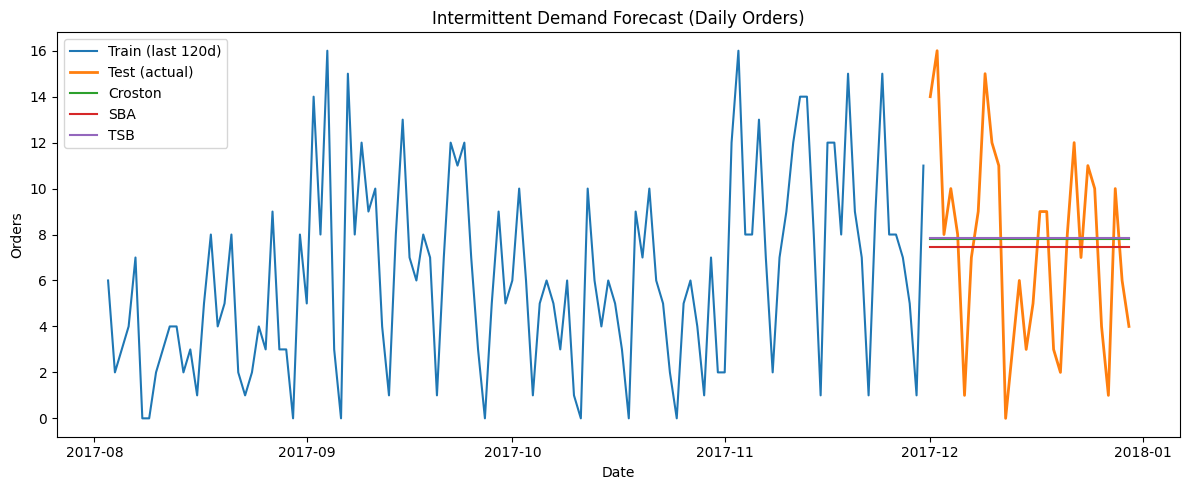

In [36]:
plt.figure(figsize=(12,5))
plt.plot(train.tail(120), label="Train (last 120d)")
plt.plot(test, label="Test (actual)", linewidth=2)

plt.plot(cro_fc, label="Croston")
plt.plot(sba_fc, label="SBA")
plt.plot(tsb_fc, label="TSB")

plt.title("Intermittent Demand Forecast (Daily Orders)")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.legend()
plt.tight_layout()
plt.show()


In [37]:
h_future = 30
future_idx = pd.date_range(y.index[-1] + pd.Timedelta(days=1), periods=h_future, freq="D")

best_name = results.iloc[0]["Model"]

if best_name == "Croston":
    fc_vals, _ = croston_forecast(y.values, h_future, alpha=0.1)
elif best_name == "SBA":
    fc_vals, _ = sba_forecast(y.values, h_future, alpha=0.1)
else:
    fc_vals, _ = tsb_forecast(y.values, h_future, alpha=0.1, beta=0.1)

future_fc = pd.Series(fc_vals, index=future_idx, name=f"{best_name}_forecast")
future_fc.head()


,SBA_forecast
2017-12-31,6.367367
2018-01-01,6.367367
2018-01-02,6.367367
2018-01-03,6.367367
2018-01-04,6.367367


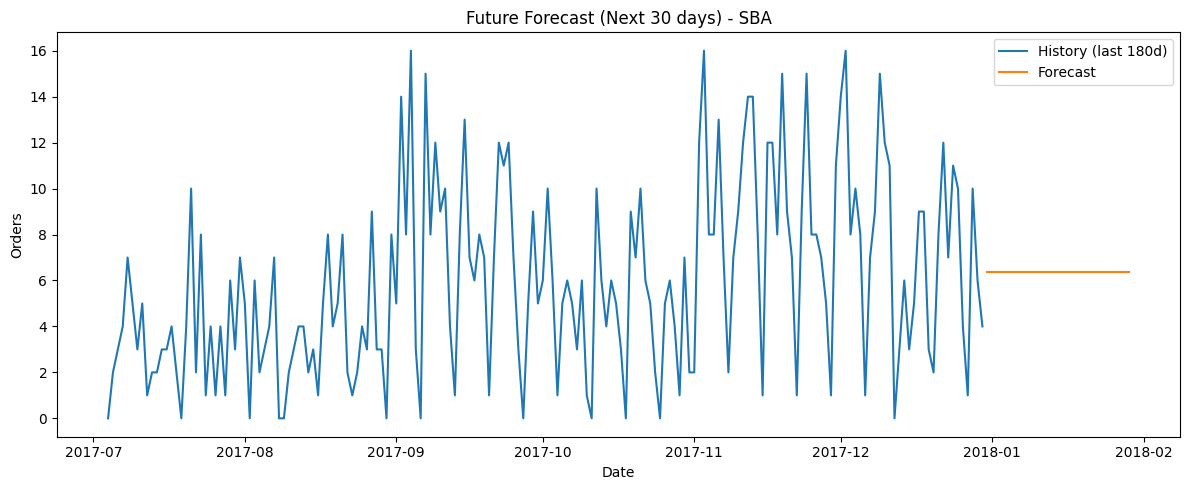

In [38]:
plt.figure(figsize=(12,5))
plt.plot(y.tail(180), label="History (last 180d)")
plt.plot(future_fc, label="Forecast")
plt.title(f"Future Forecast (Next {h_future} days) - {best_name}")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
import os
import pickle
import numpy as np

os.makedirs("models", exist_ok=True)

def fit_croston_state(y, alpha=0.1):
    y = np.asarray(y, dtype=float)

    nz = np.where(y > 0)[0]
    if len(nz) == 0:
        return {"method": "croston", "alpha": alpha, "z": 0.0, "p": 1.0, "rate": 0.0}

    first = nz[0]
    z = y[first]
    p = max(1.0, first + 1.0)
    q = 0

    for t in range(len(y)):
        if y[t] > 0:
            z = alpha * y[t] + (1 - alpha) * z
            p = alpha * (q + 1) + (1 - alpha) * p
            q = 0
        else:
            q += 1

    rate = z / max(p, 1e-9)
    return {"method": "croston", "alpha": alpha, "z": z, "p": p, "rate": rate}

def fit_sba_state(y, alpha=0.1):
    st = fit_croston_state(y, alpha=alpha)
    corr = (1 - alpha / 2.0)
    st["method"] = "sba"
    st["corr"] = corr
    st["rate"] = st["rate"] * corr
    return st

def fit_tsb_state(y, alpha=0.1, beta=0.1):
    y = np.asarray(y, dtype=float)

    nz = np.where(y > 0)[0]
    if len(nz) == 0:
        return {"method": "tsb", "alpha": alpha, "beta": beta, "z": 0.0, "p": 0.0, "rate": 0.0}

    first = nz[0]
    z = y[first]
    p = 1.0 / (first + 1.0)

    for t in range(len(y)):
        if y[t] > 0:
            p = beta * 1.0 + (1 - beta) * p
            z = alpha * y[t] + (1 - alpha) * z
        else:
            p = beta * 0.0 + (1 - beta) * p

    rate = p * z
    return {"method": "tsb", "alpha": alpha, "beta": beta, "z": z, "p": p, "rate": rate}



bundle = fit_tsb_state(train.values, alpha=0.1, beta=0.1)  # <-- change to croston/sba if needed

with open("models/intermittent_model.pkl", "wb") as f:
    pickle.dump(bundle, f)

print("Saved: models/intermittent_model.pkl")
print(bundle)


Saved: models/intermittent_model.pkl
{'method': 'tsb', 'alpha': 0.1, 'beta': 0.1, 'z': np.float64(7.864103779858041), 'p': np.float64(0.9960155720725107), 'rate': np.float64(7.8327698251329005)}
